In [1]:
# !pip install --upgrade tensorflow
!pip install tensorflow==2.15
!pip install -U tf_keras # Keras 2
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip install transformers datasets tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [2]:
# !pip install --upgrade transformers

In [3]:
# !pip show tensorflow
# !pip show Keras

In [4]:
import os
import tensorflow as tf
from tensorflow import keras
from transformers import TFElectraForSequenceClassification, ElectraTokenizer
from datasets import load_dataset, load_metric
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
drive.mount('/content/drive')

# Saved fine tuned model
load_model_path = '/content/drive/My Drive/W266_Final_Project/Finetune_BASE_GLUE/exp05/electra-base-exp05-qnli-final'

Mounted at /content/drive


In [6]:
# https://colab.research.google.com/drive/1VoWyzlXZVR5sNygejktJ4Uguw3HIZckb?usp=sharing

# Load ELECTRA BASE fine tuned
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = TFElectraForSequenceClassification.from_pretrained(load_model_path)

# Load and preprocess the GLUE QNLI dataset
# https://huggingface.co/docs/datasets/v1.1.2/loading_datasets.html
# https://huggingface.co/docs/datasets/en/process
# https://huggingface.co/datasets/nyu-mll/glue
dataset = load_dataset("glue", "qnli")
metric = load_metric("glue", "qnli")

encoded_dataset = dataset.map(lambda examples: tokenizer(examples["question"],
                                                         examples["sentence"],
                                                         truncation=True,
                                                         padding="max_length",
                                                         return_tensors="tf"),
                              batched=True)

# Convert to TensorFlow dataset
# https://huggingface.co/docs/datasets/v1.16.1/use_dataset.html
validation_data = encoded_dataset["validation"].to_tf_dataset(columns=["attention_mask", "input_ids", "token_type_ids"],
                                                              label_cols=["label"],
                                                              shuffle=False,
                                                              batch_size=32)

# Predict
# https://huggingface.co/docs/datasets/v1.12.0/metrics.html
predictions = model.predict(validation_data)['logits']
predicted_labels = np.argmax(predictions, axis=1)
true_labels = [example['label'] for example in dataset['validation']]
accuracy = metric.compute(predictions=predicted_labels, references=true_labels)

print('Accuracy on QNLI validation set:', accuracy['accuracy'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/W266_Final_Project/Finetune_BASE_GLUE/exp05/electra-base-exp05-qnli-final.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

<ipython-input-6-1dc4554af55f>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "qnli")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/104743 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


171/171 [==============================] - 44s 147ms/step
Accuracy on QNLI validation set: 0.9170785282811642


- ELECTRA BASE fine tuned on GLUE QNLI for Question Answering and then Benchmarked on the same GLUE QNLI for Question Answering
  - Freeze first 4 layers, fine-tune on last 8 layers
- Ran in Google Colab Pro+ on A100 GPU and High RAM
  - System RAM 3.3GB
  - GPU RAM 4.4GB
  - Ran in about 44 seconds
- Accuracy on QNLI validation set: 0.9170785282811642

## Performance Evaluation

### Confusion Matrix

[[2413  289]
 [ 164 2597]]


<Axes: >

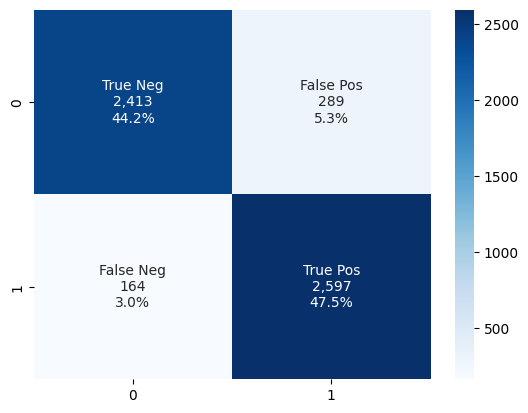

In [7]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

Confusion_Matrix = confusion_matrix(true_labels, predicted_labels)
print(Confusion_Matrix)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{:,}".format(value) for value in Confusion_Matrix.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in Confusion_Matrix.flatten()/np.sum(Confusion_Matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(Confusion_Matrix, annot=labels, fmt='', cmap='Blues')



---



### F1 Score, Precision, and Recall

In [8]:
F1_Score = f1_score(true_labels, predicted_labels)
Precision = precision_score(true_labels, predicted_labels)
Recall = recall_score(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
specificity = tn / (tn + fp)

print("F1 Score:\t", round(F1_Score, 4))
print("Precision:\t", round(Precision, 4))
print("Recall:\t\t", round(Recall, 4))
print("Accuracy:\t", round(accuracy, 4))
print("Specificity:\t", round(specificity, 4))



F1 Score:	 0.9198
Precision:	 0.8999
Recall:		 0.9406
Accuracy:	 0.9171
Specificity:	 0.893
